In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import QuantileTransformer

In [2]:
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         15000 non-null  int64  
 1   Q1            14959 non-null  float64
 2   Q2            14931 non-null  float64
 3   Q3            14950 non-null  float64
 4   Q4            14929 non-null  float64
 5   Q5            14962 non-null  float64
 6   Q6            14952 non-null  float64
 7   Q7            14924 non-null  float64
 8   Q8            14952 non-null  float64
 9   Q9            14944 non-null  float64
 10  Q10           14928 non-null  float64
 11  Q11           14941 non-null  float64
 12  Q12           14933 non-null  float64
 13  Q13           14960 non-null  float64
 14  Q14           14964 non-null  float64
 15  Q15           14955 non-null  float64
 16  Q16           14967 non-null  float64
 17  Q17           14963 non-null  float64
 18  Q18           14937 non-nu

In [4]:
li=train.columns
li=li.tolist()
li[68]

'ASD'

In [5]:
test

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,gender,engnat,age,hand,religion,orientation,voted,married,familysize,ASD
0,0,4.0,4.0,3.0,5.0,5.0,5.0,3.0,5.0,4.0,...,2.0,2.0,19,1.0,4.0,4.0,1.0,1.0,3.0,2.0
1,1,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,...,1.0,1.0,33,1.0,1.0,5.0,2.0,1.0,5.0,2.0
2,2,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,...,2.0,2.0,13,1.0,4.0,5.0,2.0,1.0,3.0,2.0
3,3,5.0,4.0,3.0,4.0,5.0,4.0,5.0,4.0,4.0,...,1.0,1.0,28,1.0,2.0,2.0,2.0,1.0,3.0,2.0
4,4,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,...,2.0,2.0,15,1.0,4.0,5.0,2.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35447,35447,4.0,5.0,5.0,3.0,3.0,4.0,5.0,5.0,4.0,...,2.0,2.0,16,3.0,10.0,4.0,2.0,1.0,3.0,2.0
35448,35448,5.0,5.0,5.0,5.0,5.0,4.0,5.0,3.0,5.0,...,3.0,1.0,16,3.0,2.0,5.0,2.0,1.0,2.0,2.0
35449,35449,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,1.0,1.0,31,1.0,1.0,5.0,1.0,1.0,2.0,2.0
35450,35450,5.0,5.0,4.0,5.0,5.0,1.0,5.0,1.0,5.0,...,1.0,1.0,19,1.0,12.0,1.0,2.0,1.0,NaN,2.0


In [6]:
train=train.fillna(train.mean())
#train=train.drop("country",axis=1)
train=train.drop("index",axis=1)

test=test.fillna(test.mean())
#test=test.drop("country",axis=1)
test=test.drop("index",axis=1)

for i in range(27,69,1):
    train=train.drop(columns=li[i],axis=1)
    test=test.drop(columns=li[i],axis=1)




/var/folders/y2/lkm0p1s979jf_rsdx_9cgc0w0000gn/T/ipykernel_44024/2583085463.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train=train.fillna(train.mean())
/var/folders/y2/lkm0p1s979jf_rsdx_9cgc0w0000gn/T/ipykernel_44024/2583085463.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test=test.fillna(test.mean())


In [7]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Q1         15000 non-null  float64
 1   Q2         15000 non-null  float64
 2   Q3         15000 non-null  float64
 3   Q4         15000 non-null  float64
 4   Q5         15000 non-null  float64
 5   Q6         15000 non-null  float64
 6   Q7         15000 non-null  float64
 7   Q8         15000 non-null  float64
 8   Q9         15000 non-null  float64
 9   Q10        15000 non-null  float64
 10  Q11        15000 non-null  float64
 11  Q12        15000 non-null  float64
 12  Q13        15000 non-null  float64
 13  Q14        15000 non-null  float64
 14  Q15        15000 non-null  float64
 15  Q16        15000 non-null  float64
 16  Q17        15000 non-null  float64
 17  Q18        15000 non-null  float64
 18  Q19        15000 non-null  float64
 19  Q20        15000 non-null  float64
 20  Q21   

In [8]:
import xgboost# index introelapse orientation
from xgboost import XGBRegressor
from xgboost import XGBRegressor as model
from lightgbm import LGBMClassifier

y = train['nerdiness']
x= train.drop('nerdiness',axis =1)
model = XGBRegressor(objective='reg:squarederror',learning_rate=0.1,max_depth = 4, n_estimators = 1000)
model.fit(x, y)
pred = model.predict(test)      
pred = pd.DataFrame(pred, columns=['nerdiness'])
pred['nerdiness'].tolist()


[0.6439275741577148,
 0.8542234897613525,
 0.9171721935272217,
 0.6422208547592163,
 0.5272350907325745,
 -0.1265600472688675,
 0.765589714050293,
 0.8248270153999329,
 0.6235700845718384,
 0.3981607258319855,
 0.3802473545074463,
 0.9300547242164612,
 0.9361156821250916,
 0.21604646742343903,
 0.8843235373497009,
 0.22355416417121887,
 0.021963344886898994,
 0.6858231425285339,
 0.7222806811332703,
 0.7643051147460938,
 0.2169603854417801,
 0.29286304116249084,
 0.7245606780052185,
 0.5894979238510132,
 0.17264573276042938,
 0.6771162748336792,
 0.8534157276153564,
 0.8604360818862915,
 0.39605623483657837,
 0.06130150705575943,
 0.058971866965293884,
 -0.04054824262857437,
 0.8380192518234253,
 0.468117892742157,
 0.9614236950874329,
 0.10507112741470337,
 0.3487749993801117,
 0.29708531498908997,
 0.5419748425483704,
 0.7706477642059326,
 0.8969882130622864,
 0.28038108348846436,
 0.7500935792922974,
 0.03508686646819115,
 0.7895714044570923,
 0.15621809661388397,
 0.710441172122955

In [9]:
sample['nerdiness'] = pred.round(0)
sample


sample.to_csv('result8.2_2.csv',index=False)

In [10]:
sample.head(50)

,index,nerdiness
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0
5,5,-0.0
6,6,1.0
7,7,1.0
8,8,1.0
9,9,0.0


<AxesSubplot:>

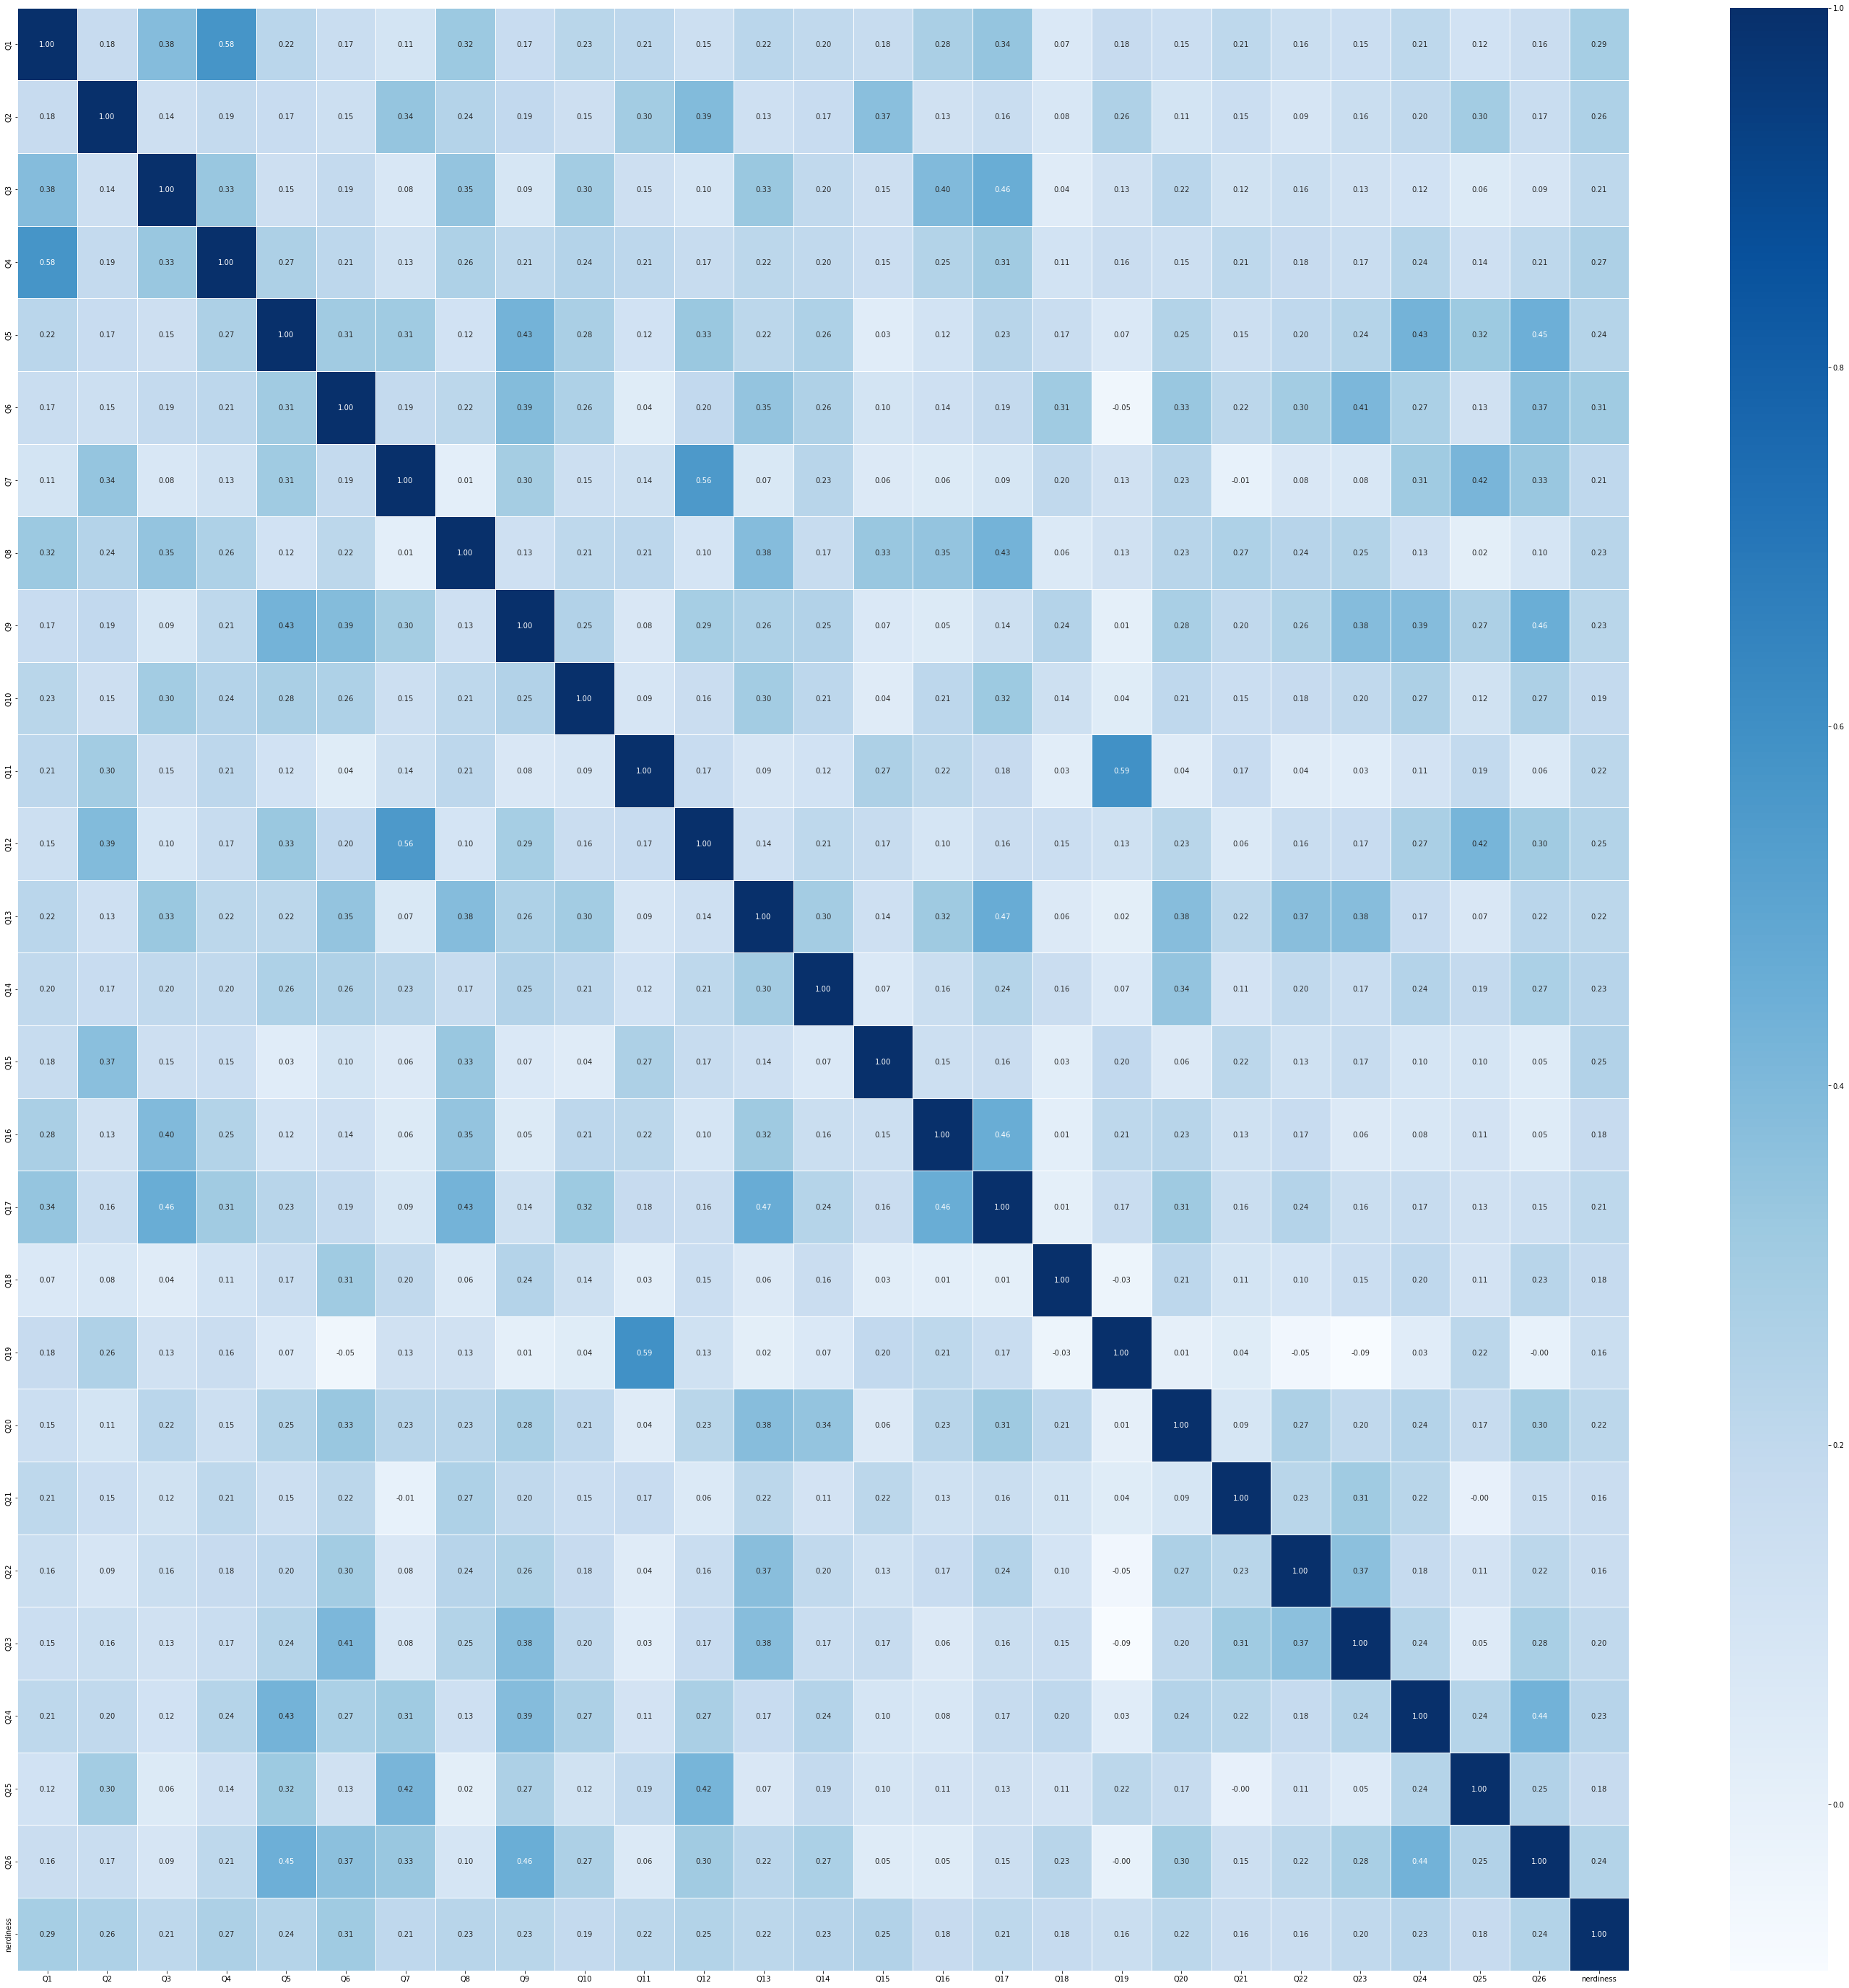

In [11]:
plt.figure(figsize=(50,50))
sns.heatmap(data = train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [15]:
#https://dacon.io/codeshare/1877
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [16]:
country_map = {}

for i, c in enumerate(train['country'].unique()):
    country_map[c] = i

In [18]:
train['country'] = train['country'].map(country_map)
test['country'] = test['country'].map(country_map) #country열 Mapping

In [20]:
test.isna().sum()

index            0
Q1             119
Q2             147
Q3             130
Q4             125
              ... 
orientation    823
voted          181
married        180
familysize     703
ASD            237
Length: 69, dtype: int64

In [22]:
test = test.fillna(test.mean())
train = train.fillna(train.mean())#test 결측치 0으로 채우기

In [23]:
x_train = train.loc[:, 'Q1':'ASD']
y_train = train['nerdiness']

x_test = test.loc[:, 'Q1':'ASD'] #index와 nerdiness열 제외

In [25]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42, n_jobs=-1)

from sklearn.model_selection import KFold, GridSearchCV #하이퍼파라미터 튜닝을 위한 불러오기
from sklearn.metrics import accuracy_score

model_param_grid = {'n_estimators' : [100, 1000, 3000]} # Default(100)대비 큰값으로 Dictionary구성

model_grid = GridSearchCV(model, param_grid = model_param_grid, scoring="accuracy",n_jobs=-1,verbose=1) #훈련 (장치 사양에 따라 시간이 걸릴 수 있음)
model_grid.fit(x_train, y_train)

pred = model_grid.predict_proba(x_test)[:,1] #proba를 통해 확률값으로 변환

sample['nerdiness'] = pred
'''
cv=KFold(n_splits=6, random_state=42) #교차검증

gcv=GridSearchCV(model, param_grid=model_param_grid, cv=cv, scoring='f1', n_jobs=-1)

gcv.fit(x_train.values,y_train.values)
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력

model = RandomForestClassifier(n_estimators=3000, random_state=42, n_jobs=-1)

model.fit(x_train, y_train) #학습

pred = model.predict_proba(x_test)[:,1] #proba를 통해 확률값으로 변환

submission['nerdiness'] = pred

'''

Fitting 5 folds for each of 3 candidates, totalling 15 fits


"\ncv=KFold(n_splits=6, random_state=42) #교차검증\n\ngcv=GridSearchCV(model, param_grid=model_param_grid, cv=cv, scoring='f1', n_jobs=-1)\n\ngcv.fit(x_train.values,y_train.values)\nprint('final params', gcv.best_params_)   # 최적의 파라미터 값 출력\n\nmodel = RandomForestClassifier(n_estimators=3000, random_state=42, n_jobs=-1)\n\nmodel.fit(x_train, y_train) #학습\n\npred = model.predict_proba(x_test)[:,1] #proba를 통해 확률값으로 변환\n\nsubmission['nerdiness'] = pred\n\n"

In [28]:
sample['nerdiness']=sample['nerdiness'].round(0)

In [29]:
sample.to_csv('result8.2_3.csv',index=False)